In [1]:
import pennylane as qml
from pennylane import numpy as np
from Qsun.Qcircuit import *
from Qsun.Qgates import *
import time

# Quantum Machine Learning

In [2]:
import matplotlib.pyplot as plt
# import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
X, y = datasets.load_diabetes(return_X_y=True)

In [4]:
X, y = datasets.load_diabetes(return_X_y=True)
y = (y - np.min(y)) / (np.max(y) - np.min(y))
# Use only one feature
X = X[:, np.newaxis, 2]

# Split the data into training/testing sets
X_train = X[:400]
X_test = X[-10:]

# Split the targets into training/testing sets
y_train = y[:400]
y_test = y[-10:]

In [5]:
feature_matrix = np.hstack((X_train, np.ones((len(X_train), 1))))

In [6]:
theta = np.dot(feature_matrix.T, feature_matrix)
theta = np.linalg.inv(theta)
theta = np.dot(theta, feature_matrix.T)
theta = np.dot(theta, y_train)
theta

array([2.97726802, 0.39875447])

In [7]:
test_matrix = np.hstack((X_test, np.ones((len(X_test), 1))))

In [8]:
y_pred_exact = np.dot(test_matrix, theta)

## Classic

In [9]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [2.97726802]
Intercept: 
 0.3987544671550144
Mean squared error: 0.02
Coefficient of determination: 0.40


In [10]:
mean_squared_error(y_test, y_pred)

0.020474527452362327

## QVM

In [15]:
from Qsun.Qcircuit import *
from Qsun.Qgates import *
from Qsun.Qmeas import *

In [16]:
def circuit(params):
    c = Qubit(1)
    RX(c, 0, params[0])
    RY(c, 0, params[1])
    return c

def output(params):
    c = circuit(params)
    prob = c.probabilities()
#     measure_output =  measure_all(c, 10000)[1]
#     prob = measure_output/sum(measure_output)
    return 1*prob[0] - 1*prob[1]

def predict(x_true, coef_params, intercept_params, boundary=10):
    coef = boundary*output(coef_params)
    intercept = boundary*output(intercept_params)
    return coef*x_true.flatten() + intercept

def errors(x_true, y_true, coef_params, intercept_params, boundary):
    return mean_squared_error(y_true, predict(x_true, coef_params, intercept_params, boundary))

def grad(x_true, y_true, coef_params, intercept_params, shift, eta, boundary):
    
    coef_diff = np.zeros((2,))
    intercept_diff = np.zeros((2,))
    
    for i in range(len(coef_params)):
        coef_params_1 = coef_params.copy()
        coef_params_2 = coef_params.copy()
        coef_params_1[i] += shift
        coef_params_2[i] -= shift
        for x, y in zip(x_true, y_true):
            coef_diff[i] -= x*(y-predict(x, coef_params, intercept_params, boundary))*(output(coef_params_1)-output(coef_params_2))/(2*np.sin(shift))
            
        
    for i in range(len(coef_params)):
        intercept_params_1 = intercept_params.copy()
        intercept_params_2 = intercept_params.copy()
        intercept_params_1[i] += shift
        intercept_params_2[i] -= shift
        for x, y in zip(x_true, y_true):
            intercept_diff[i] -= (y-predict(x, coef_params, intercept_params, boundary))*(output(intercept_params_1)-output(intercept_params_2))/(2*np.sin(shift))
     
    coef_diff = coef_diff*boundary*2/len(y_true)
    intercept_diff = intercept_diff*boundary*2/len(y_true)
    
    for i in range(len(coef_params)):
        coef_params[i] = coef_params[i] - eta*coef_diff[i]
        
    for i in range(len(intercept_params)):
        intercept_params[i] = intercept_params[i] - eta*intercept_diff[i]
        
    return coef_params, intercept_params

In [17]:
# # before training
coef_params = np.array([-1.03295171, -0.64020581])
intercept_params = np.array([ 0.84085179, -0.5721947 ])

In [18]:
start = time.time()
costs_train_qlr = []
costs_test_qlr = []
for i in range(1000):
    coef_params, intercept_params = grad(X_train, y_train, coef_params, intercept_params, np.pi/20, eta=0.1, boundary=10)
#     costs_train_qlr.append(errors(X_train, y_train, coef_params, intercept_params, boundary))
#     costs_test_qlr.append(errors(X_test, y_test, coef_params, intercept_params, boundary))
end = time.time()  

## Pennylane

In [19]:
import autograd.numpy as np_grad

In [20]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit_qml(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RX(params[2], wires=1)
    qml.RY(params[3], wires=1)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

def cost(params):
    expval = circuit_qml(params)
    coef = boundary*expval[0]
    intercept = boundary*expval[1]
    y_pred_qml = coef*X_train.flatten() + intercept
    return np_grad.mean((y_train-y_pred_qml)**2)

In [21]:
boundary = 10
params = np.random.normal(size=(4,))
opt = qml.GradientDescentOptimizer()
steps = 1000

In [22]:
params = np.random.normal(size=(4,))
cost(params)

tensor(38.89865284, requires_grad=True)

In [23]:
start = time.time()
for i in range(steps):
    params = opt.step(cost, params)   
end = time.time()

In [24]:
expval = circuit_qml(params)
coef = boundary*expval[0]
intercept = boundary*expval[1]
y_pred_qml = coef*X_test.flatten() + intercept

## ProjectQ

In [11]:
from projectq import MainEngine
import projectq.ops as ops
from projectq.backends import Simulator
import itertools

In [12]:
def circuit(params):
    
    eng = MainEngine(backend=Simulator(gate_fusion=True),engine_list=[])
    qbits = eng.allocate_qureg(1)
    
    ops.Rx(params[0]) | qbits[0]
    ops.Ry(params[1]) | qbits[0]
    
    strings = ["".join(seq) for seq in itertools.product("01", repeat=1)]
    probs = np.array([eng.backend.get_probability(i, qbits) for i in strings])
    
    ops.All(ops.Measure)|qbits
    eng.flush()
    
    return probs

def output(params):
    prob = circuit(params)
#     measure_output =  measure_all(c, 10000)[1]
#     prob = measure_output/sum(measure_output)
    return 1*prob[0] - 1*prob[1]

def predict(x_true, coef_params, intercept_params, boundary=10):
    coef = boundary*output(coef_params)
    intercept = boundary*output(intercept_params)
    return coef*x_true.flatten() + intercept

def errors(x_true, y_true, coef_params, intercept_params, boundary):
    return mean_squared_error(y_true, predict(x_true, coef_params, intercept_params, boundary))

def grad(x_true, y_true, coef_params, intercept_params, shift, eta, boundary):
    
    coef_diff = np.zeros((2,))
    intercept_diff = np.zeros((2,))
    
    for i in range(len(coef_params)):
        coef_params_1 = coef_params.copy()
        coef_params_2 = coef_params.copy()
        coef_params_1[i] += shift
        coef_params_2[i] -= shift
        for x, y in zip(x_true, y_true):
            coef_diff[i] -= x*(y-predict(x, coef_params, intercept_params, boundary))*(output(coef_params_1)-output(coef_params_2))/(2*np.sin(shift))
            
        
    for i in range(len(coef_params)):
        intercept_params_1 = intercept_params.copy()
        intercept_params_2 = intercept_params.copy()
        intercept_params_1[i] += shift
        intercept_params_2[i] -= shift
        for x, y in zip(x_true, y_true):
            intercept_diff[i] -= (y-predict(x, coef_params, intercept_params, boundary))*(output(intercept_params_1)-output(intercept_params_2))/(2*np.sin(shift))
     
    coef_diff = coef_diff*boundary*2/len(y_true)
    intercept_diff = intercept_diff*boundary*2/len(y_true)
    
    for i in range(len(coef_params)):
        coef_params[i] = coef_params[i] - eta*coef_diff[i]
        
    for i in range(len(intercept_params)):
        intercept_params[i] = intercept_params[i] - eta*intercept_diff[i]
        
    return coef_params, intercept_params

In [13]:
# # before training
coef_params_projectq = np.random.normal(size=(2,))
intercept_params_projectq = np.random.normal(size=(2,))

In [1]:
start = time.time()
for i in range(1000):
    coef_params_projectq, intercept_params_projectq = grad(X_train, y_train, coef_params_projectq, intercept_params_projectq, np.pi/20, eta=0.1, boundary=10)
#     costs_train_qlr.append(errors(X_train, y_train, coef_params, intercept_params, boundary))
#     costs_test_qlr.append(errors(X_test, y_test, coef_params, intercept_params, boundary))
    print(i)
end = time.time()  

In [25]:
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SIZE = 34*1.3

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

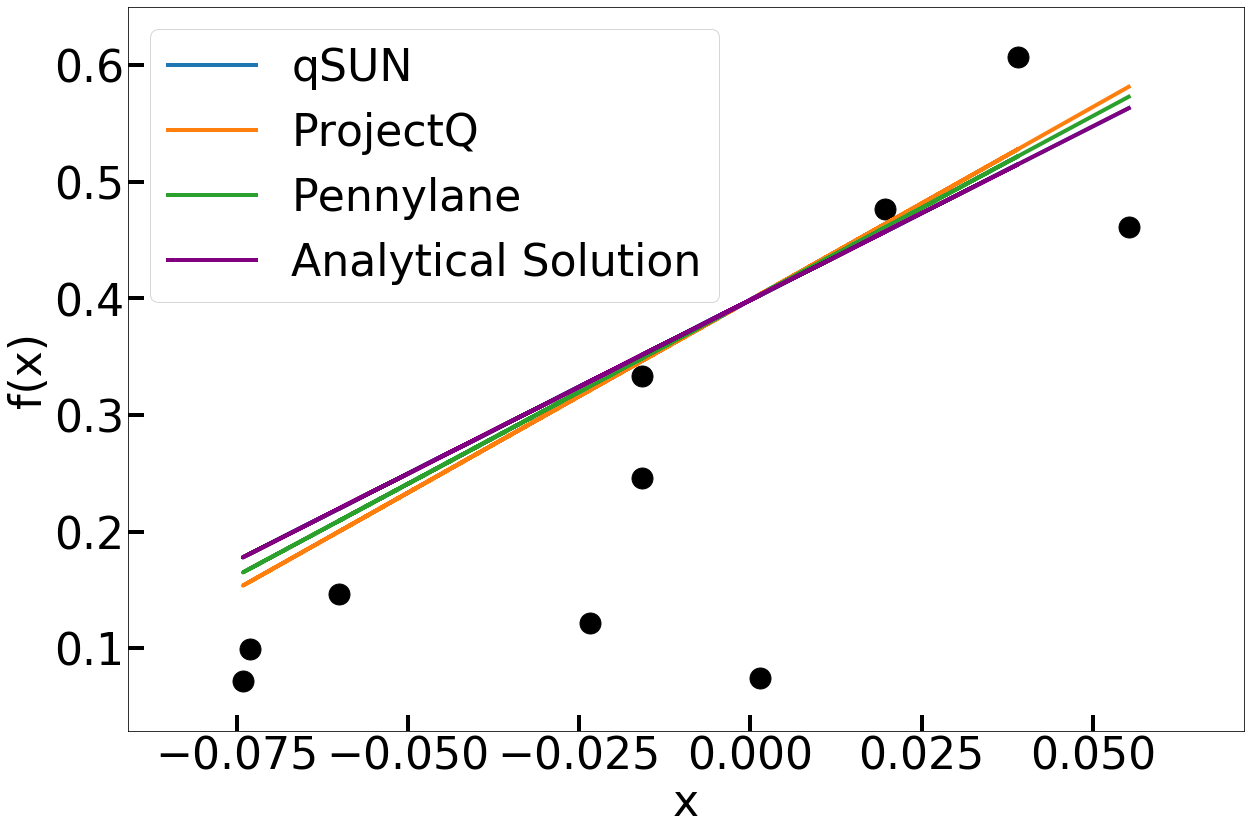

In [32]:
plt.figure(figsize=(20,13.33))
plt.scatter(X_test, y_test, s=440, color='black', )
plt.plot(X_test, predict(X_test, coef_params, intercept_params, boundary=10), linewidth=4, label='qSUN')
plt.plot(X_test, predict(X_test, coef_params_projectq, intercept_params_projectq, boundary=10), linewidth=4, label='ProjectQ')
plt.plot(X_test, y_pred_qml, linewidth=4, label='Pennylane')
plt.plot(X_test, y_pred_exact, linewidth=4, label='Analytical Solution', color='purple')
# plt.plot(X_test, predict(X_test, coef_params, intercept_params, boundary=10), 'o--', linewidth=4, markersize=24, label='qSUN')
# plt.plot(X_test, y_pred_qml, 'v--', linewidth=4, markersize=24, label='Pennylane')
# plt.plot(X_test, y_pred, 'd--', linewidth=4, markersize=24, label='scikit-learn', color='purple')
plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.savefig('compare_linear_regression_projectq.png')
plt.savefig('compare_linear_regression_projectq.eps', format='eps')